In [124]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import random
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud 

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve,auc,recall_score,precision_score
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL


%matplotlib inline

In [125]:
train=pd.read_csv("train.csv/train.csv")
test=pd.read_csv("test.csv/test.csv")

train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [126]:

train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [127]:
train.dtypes

id        int64
label     int64
tweet    object
dtype: object

In [128]:

train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


In [129]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [130]:
train["label"].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

In [131]:
print(f' null values \n{train.isnull().any()}')

 null values 
id       False
label    False
tweet    False
dtype: bool


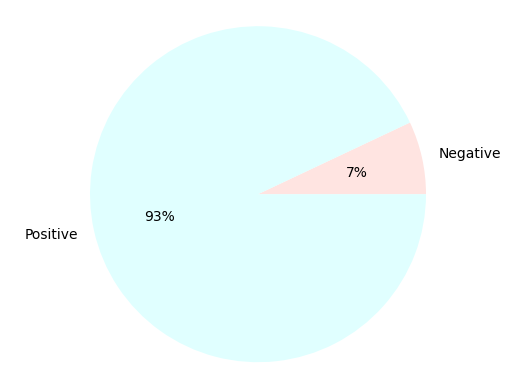

In [132]:
%matplotlib inline

labels=['Negative', 'Positive']
colors = ['mistyrose','lightcyan']
sizes=[train['label'].value_counts()[1],
     train['label'].value_counts()[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%')
ax1.axis('equal')
plt.show()

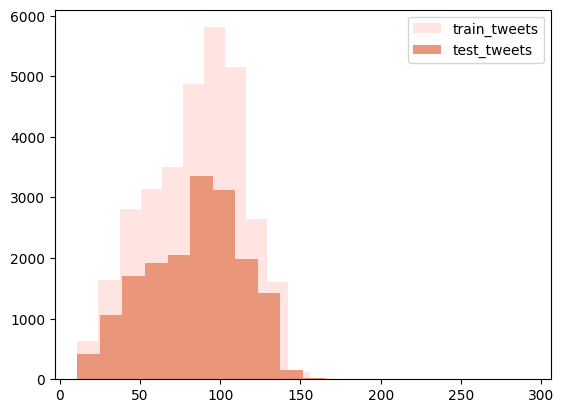

In [133]:

length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets", color='mistyrose')
plt.hist(length_test, bins=20, label="test_tweets", color='darksalmon')
plt.legend()
plt.show()

In [134]:
stop_words = stopwords.words('english')
Word = WordNetLemmatizer()

In [135]:
pos = 100*len(train.loc[train['label']==0,'label'])/len(train['label'])
neg = 100*len(train.loc[train['label']==1,'label'])/len(train['label'])
print(pos)
print(neg)

92.98542018647143
7.014579813528565


In [136]:
H = train.drop('id',axis = 'columns')

In [137]:
H = H.drop_duplicates(keep='first')
H.shape

(29530, 2)

(-0.5, 399.5, 199.5, -0.5)

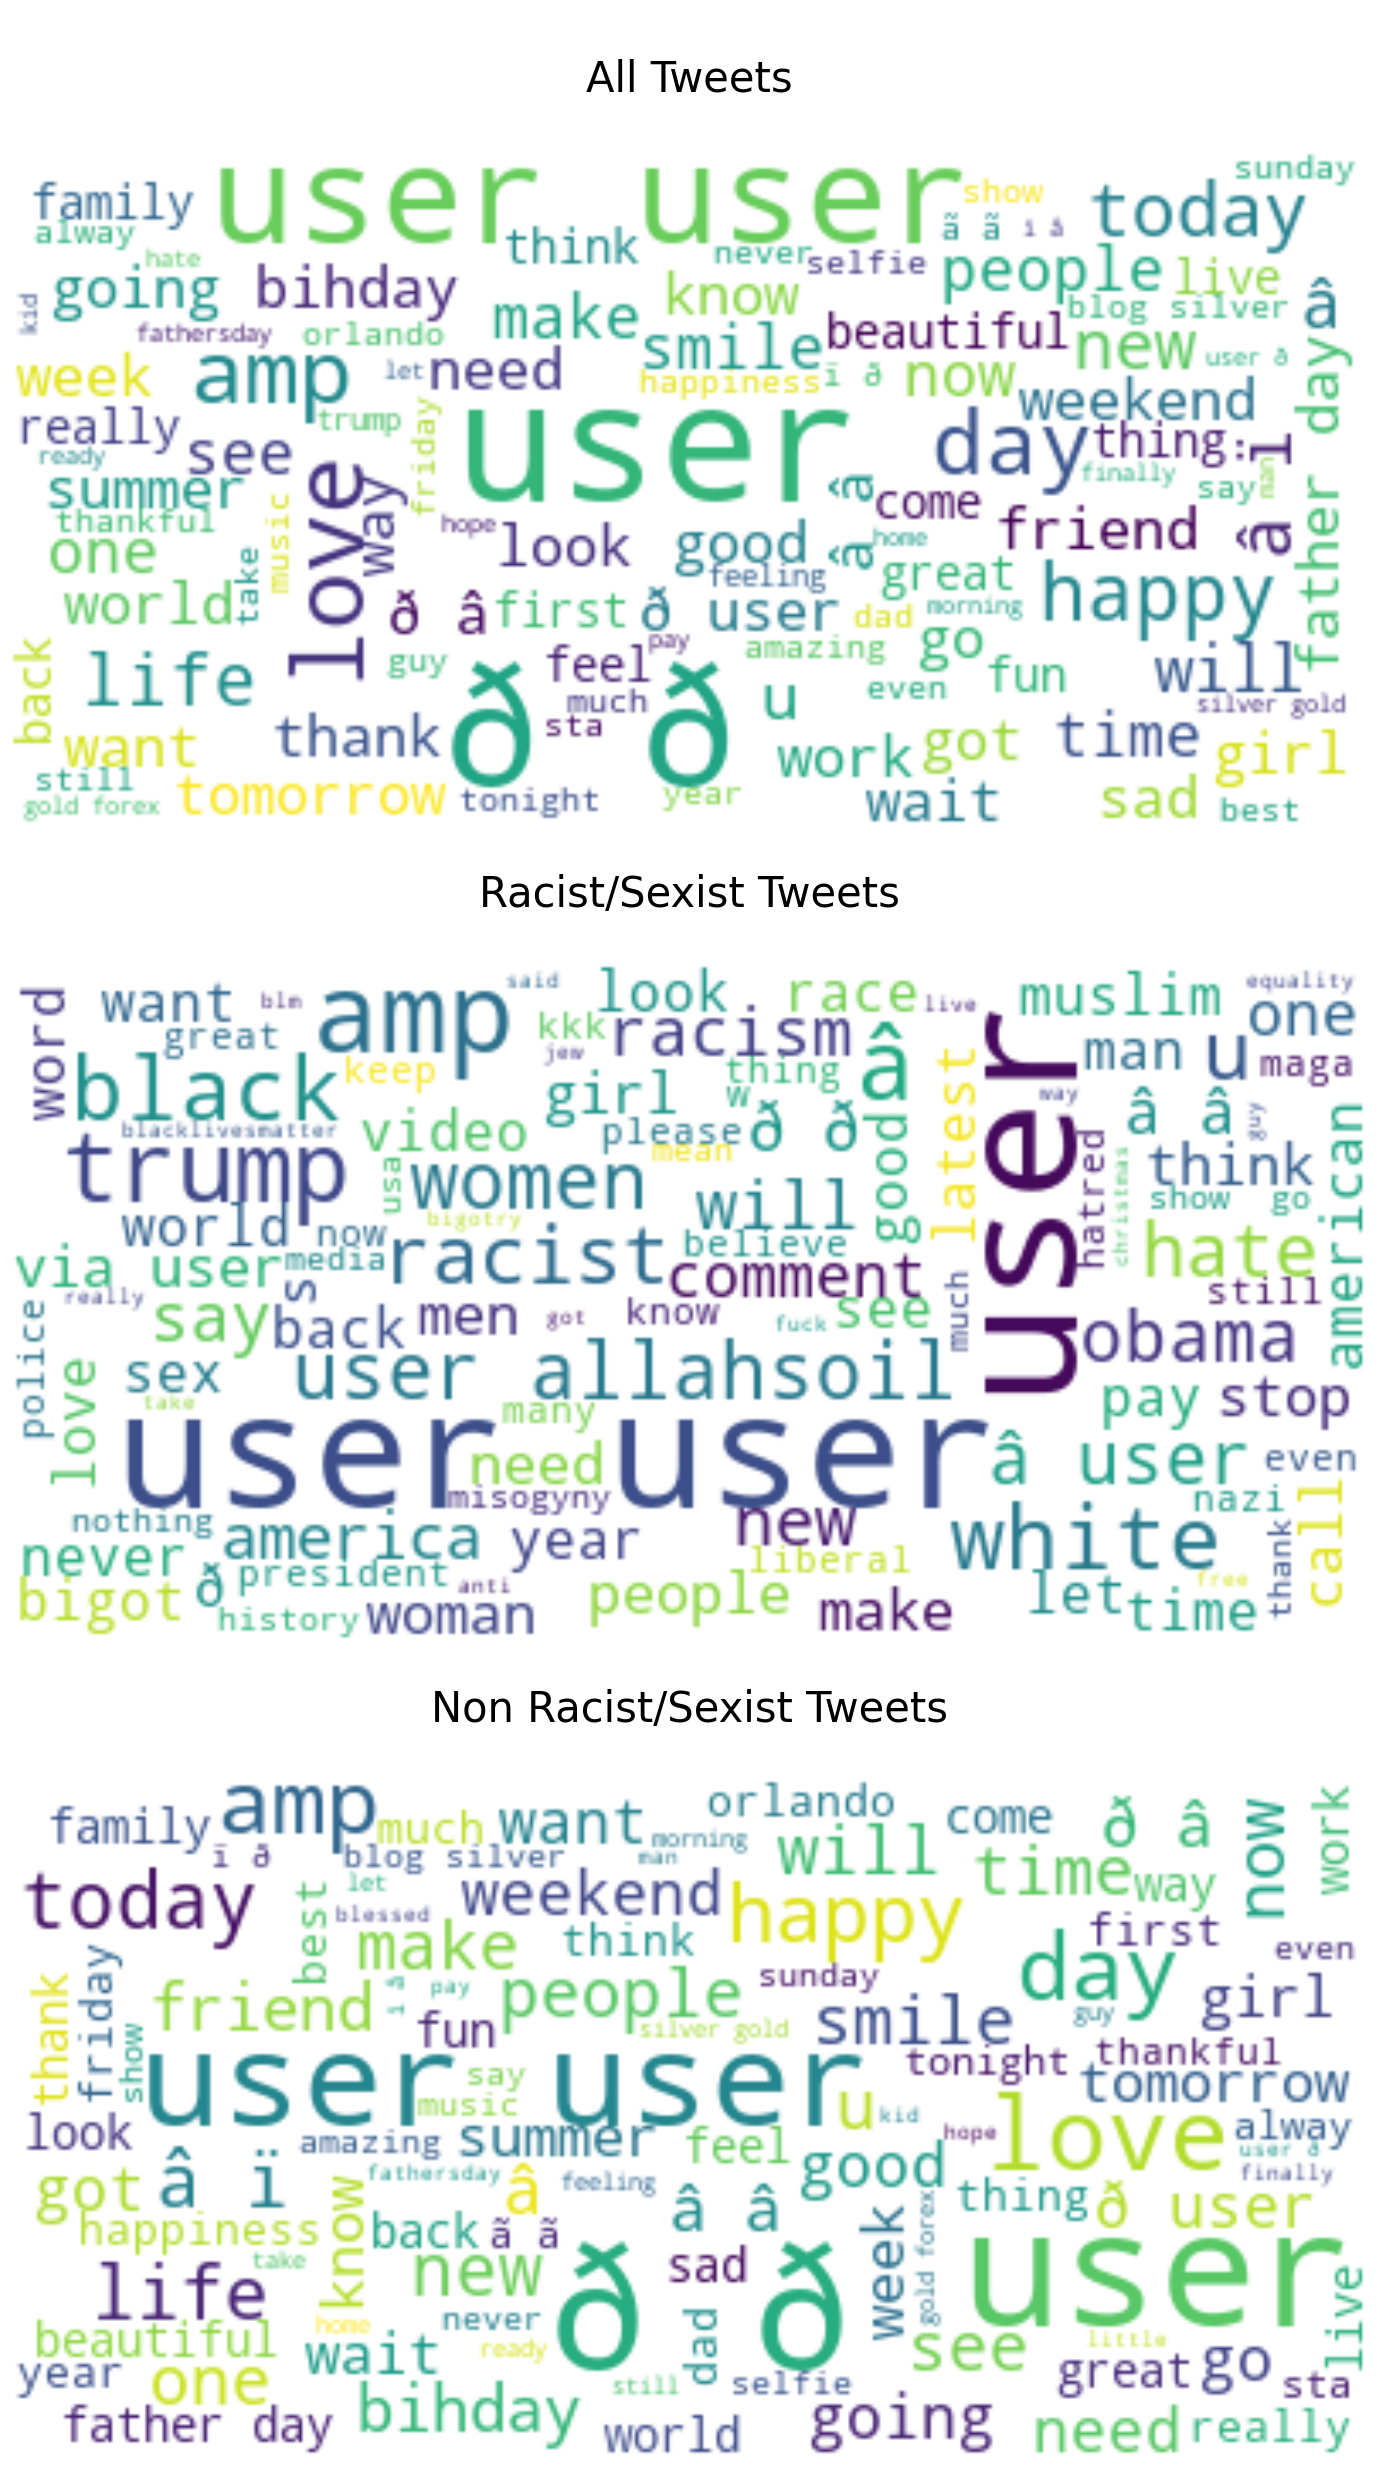

In [138]:
df_RS = H[H['label']==1]
df_NRS = H[H['label']==0]
tweet_All = " ".join(review for review in H.tweet)
tweet_RS = " ".join(review for review in df_RS.tweet)
tweet_NRS = " ".join(review for review in df_NRS.tweet)

fig, ax = plt.subplots(3, 1, figsize  = (30,30))

wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_RS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_RS)
wordcloud_NRS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_NRS)


ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('\nAll Tweets\n', fontsize=30)
ax[0].axis('off')
print('\n')
ax[1].imshow(wordcloud_RS, interpolation='bilinear')
ax[1].set_title('\nRacist/Sexist Tweets\n',fontsize=30)
ax[1].axis('off')
print('\n')
ax[2].imshow(wordcloud_NRS, interpolation='bilinear')
ax[2].set_title('\nNon Racist/Sexist Tweets\n',fontsize=30)
ax[2].axis('off')

In [139]:
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result) 
    result = re.sub('&#x27;', "'", result) 
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result) 
    result = re.sub('<i>', ' ', result) 
    result = re.sub('</i>', '', result) 
    result = re.sub('&#62;', '', result)
    result = re.sub("\n", '', result) 
    return result

In [140]:
def num_of_hash_tags(df):
    df['hashtags_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
num_of_hash_tags(H)

In [141]:

def num_of_chars(df):
    df['char_count'] = df['tweet'].apply(lambda x: sum(list(map(len,x.split(' ')))))
num_of_chars(H)

In [142]:

def num_of_words(df):
    df['word_count'] = df['tweet'].apply(lambda x : len(str(x).split(" ")))

num_of_words(H)

In [143]:

def num_of_num(df):
    df['num_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
num_of_num(H)

In [144]:

def num_of_stop_words(df):
    df['stopwords_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop_words]))
num_of_stop_words(H)

In [145]:

def num_of_upper(df):
    df['upper_case'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
num_of_upper(H)

In [146]:

def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
lower_case(H)


In [147]:

def stop_words_remove(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

def remove_word_user(df):    
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x != 'user'))

def spell_correction(df):
    df['tweet'].apply(lambda x: str(textblob(x).correct()))

def lemmatize(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))

In [148]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [149]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

In [150]:
def remove_pattern(input_txt, pattern):
    r=re.findall(pattern,input_txt)
    for i in r:
        input_txt=re.sub(i,'',input_txt)
    return input_txt

In [151]:
def cleaning(df):
    df['tweet'] = df['tweet'].apply(clean)
    df['tweet'] = df['tweet'].apply(deEmojify)
    df['tweet'] = df['tweet'].apply(lambda x: remove_punct(x))
    lower_case(df)
    stop_words_remove(df)
    remove_word_user(df)
    #spell_correction(df)
    

In [152]:
nltk.download('wordnet')
cleaning(H)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
H['tweet'] = H['tweet'].apply(tokenizer.tokenize)
H['tweet'].head()

import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
H['tweet']= H['tweet'].apply(lambda x: stemming_on_text(x))
H['tweet'].head()

In [153]:
X = H.drop('label', axis = 'columns')
y = H['label']

In [155]:
from textblob import TextBlob
tfidf_vectorizer = TfidfVectorizer(tokenizer=TextBlob, stop_words='english')
X_tweets_tfidf = tfidf_vectorizer.fit_transform(X['tweet'])

In [156]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y.values)
print(X_smote.shape, y_smote.shape)

plt.pie(pd.value_counts(y ), 
        labels=['Label 0 (Positive Tweets)', 'Label 1 (Negative Tweets)'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.show()

ValueError: could not convert string to float: 'father dysfunctional selfish drags kids dysfunction run'

In [157]:
split_index_1 = int(len(H) * 0.7)  
split_index_2 = int(len(H) * 0.85) 

train_df, val_df, test_df = H[:split_index_1], H[split_index_1:split_index_2],H[split_index_2:]

In [158]:
import numpy as np 
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from copy import deepcopy 

from keras import layers
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import AUC, Recall
from keras.callbacks import ModelCheckpoint



model = Sequential([])


model.add(layers.Input(shape=(60,50)))

model.add(layers.LSTM(units = 64, return_sequences = True))

model.add(layers.Dropout(0.2))

model.add(layers.LSTM(units = 64, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units = 64, return_sequences = True))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy', AUC(name='auc'), Recall()]
)
freq = H['label'].value_counts()
freq
weights = {0: freq.sum() / freq[0], 1: freq.sum() / freq[1]}
weights
model.fit(
    X, y, 
    
    epochs=20,
    
    class_weight=weights
)

KeyError: 46